In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ydata_profiling import ProfileReport

from src.utilities import create_merged_raw, check_folder
from src.settings import RAW_PATH, PROCESSED_PATH

# Table of Contents

- **[Train set](#1)**
    - [Exploring data structure](#1-1)
    - [General EDA](#1-2)
        - [Relation of number or rows and sales](#1-2-1)
        - [`item price` column](#1-2-2)
        - [`item_cnt_day` column](#1-2-3)
        - [Duplicates](#1-2-4)
- **[Seasonality / cycles](#2)**
- **[Test set](#3)**


<a name='1'></a>
# Train set

<a name='1-1'></a>
## Exploring data structure

In [5]:
raw_files = os.listdir(RAW_PATH)
raw_files

['sales_train.csv',
 'shops.csv',
 'test.csv',
 'item_categories.csv',
 'items.csv',
 'sample_submission.csv']

Clearly, not all of the files provided are useful for training. In particular, "test", "sample_submission" are admin, so will remove from the dict.

In [6]:
for item in ['test.csv', 'sample_submission.csv']:
    try:
        raw_files.remove(item)
    except ValueError:
        print(f'{item} not found in list')

For convinience let's add all raw files to one dict

In [7]:
raw_files_di = {}
for f in raw_files:
    path = RAW_PATH + f
    raw_files_di[f.split('.')[0]] = pd.read_csv(path)

In [8]:
# reading files and looking at headers
for el in raw_files_di:
    print(el,':\n', raw_files_di[el].head())
    print('='*30, '\n\n')

sales_train :
          date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0


shops :
                         shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"        2
3  Балашиха ТРК "Октябрь-Киномир"        3
4        Волжский ТЦ "Волга Молл"        4


item_categories :
         item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP

All the columns are more or less obvious except for `date_block_num` in the `sales_train` file and `item_category_id` in `items`, let's look at those separately. `date_block_num` first.

In [9]:
# iterating through values
for val in raw_files_di['sales_train']['date_block_num'].unique()[:4]:
    print(raw_files_di['sales_train'][raw_files_di['sales_train']['date_block_num'] == val].head())
    print('=' * 50)

         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154      999.00           1.0
1  03.01.2013               0       25     2552      899.00           1.0
2  05.01.2013               0       25     2552      899.00          -1.0
3  06.01.2013               0       25     2554     1709.05           1.0
4  15.01.2013               0       25     2555     1099.00           1.0
              date  date_block_num  shop_id  item_id  item_price  item_cnt_day
115690  21.02.2013               1       50     3880      1499.0           1.0
115691  14.02.2013               1       50     3880      1499.0           1.0
115692  21.02.2013               1       50     4128       899.0           1.0
115693  13.02.2013               1       50     4124       249.0           1.0
115694  24.02.2013               1       50     3880      1499.0           1.0
              date  date_block_num  shop_id  item_id  item_price  item_cnt_day
224

Ok, so seems like each `data_block_num` value corresponds to observations from 1 month only. Let's reconfirm.

Text(0, 0.5, 'observation counts')

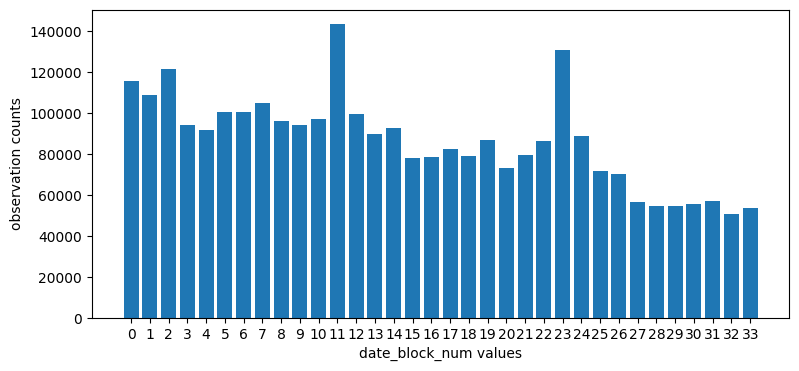

In [10]:
#inspecting the date_block_num field histogram
cntr = raw_files_di['sales_train']['date_block_num'].value_counts().sort_index()

plt.figure(figsize=[9,4])
plt.bar(cntr.index, cntr.values)
plt.xticks(ticks=cntr.index, labels=cntr.index);
plt.xlabel('date_block_num values'); plt.ylabel('observation counts')

Interesting, there are more that 12 values, so grouping is not by month only. Also, interestingly there are less observations with greater values of this feature, a clear trend. Also evident are frequency peaks on every 12th value.

Let's check if the mapping is perhaps to month/year values.

In [11]:
# casting to proper datetime type
raw_files_di['sales_train']['date'] = pd.to_datetime(raw_files_di['sales_train']['date'], format="%d.%m.%Y")

# iterating through values and checking if the corresponding combinations of month and year are unique
tmp_df = raw_files_di['sales_train'].copy()
tmp_df['month'] = raw_files_di['sales_train']['date'].dt.month
tmp_df['year'] = raw_files_di['sales_train']['date'].dt.year
grouped_tmp = tmp_df.groupby(['month', 'year'])['date_block_num'].apply(lambda x: x.unique()[0]).sort_values().reset_index()
grouped_tmp.head(15)

,month,year,date_block_num
0,1,2013,0
1,2,2013,1
2,3,2013,2
3,4,2013,3
4,5,2013,4
5,6,2013,5
6,7,2013,6
7,8,2013,7
8,9,2013,8
9,10,2013,9


In [12]:
# visually it checked out, let's verify precisely
grouped_tmp.shape[0] == len(grouped_tmp['date_block_num'].unique())

True

Indeed we see that the `date_block_num` feature represents grouping of observations by combinations of month and year.

Let's now look at `item_category_id` column.

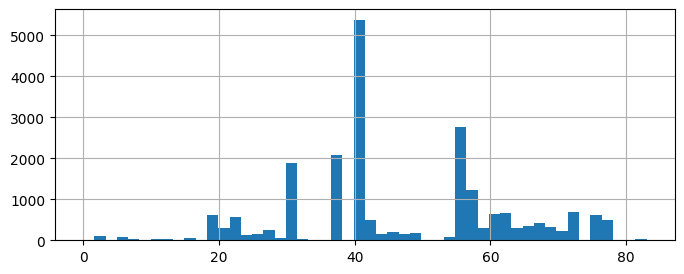

In [13]:
#inspecting the field histogram
plt.figure(figsize=[8, 3])
raw_files_di['items']['item_category_id'].hist(bins = 50);

We see that the field has more than 1 value and some values are much more frequent that others. That means that this column explains some variery in the data and hence could be usefull.

Some observations on data structure:

- `shops` -- a mapping of shops names to an ordinal categorical feature `shop_id`
- `item_categories` -- list of items' categories
- `items` -- unique list of items in stock, already merged with `item_categories` table
- `sales_train` -- main table for training with IDs of shops, items and sales date. Additional columns are `price` and `date_block_num`. 
    - `date_block_num` -- grouping of items by date, i.e. each value marks observations recorded within 1 month of the same year only. 
    - `price` -- price of item.

As we've seen, `item_categories` field has many values, so it makes sense to add this column to the main table `sales_train` by joining the `items` table and explore the data in the merged table afterwards. Let's do that.


<a name='1-2'></a>
## General EDA

In [22]:
# adding categories to the main train file
if not os.path.exists(PROCESSED_PATH + 'merged_train_df.parquet'):
    create_merged_raw()

In [26]:
merged_df = pd.read_parquet(PROCESSED_PATH + 'merged_train_df.parquet')
merged_df['date'] = pd.to_datetime(merged_df['date'], format="%d.%m.%Y")

merged_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
0,2013-01-02,0,59,22154,999.00,1.0,37
1,2013-01-03,0,25,2552,899.00,1.0,58
2,2013-01-05,0,25,2552,899.00,-1.0,58
3,2013-01-06,0,25,2554,1709.05,1.0,58
4,2013-01-15,0,25,2555,1099.00,1.0,56


Overall the data we are presented is of sales of various items under specified IDs and for specified price. We are given the count of the sold items, category of the sold item, the date when the sale occured on the scale of 1 day and the shop where it took place. The task is to predict the count of sales for items and shops for the next month. So in order to construct target for this train set, we need to aggregate by `date_block_num` (same as year+month, as shown above), `shop_id`, `item_id`, create feature aggregates and shift the `item_cnt_day` aggregate by 1 row to get the value for future month to predict.

Let's look at distributions, value ranges, number of empty rows and correlations in the raw columns. 

In [27]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   date              datetime64[ns]
 1   date_block_num    int64         
 2   shop_id           int64         
 3   item_id           int64         
 4   item_price        float64       
 5   item_cnt_day      float64       
 6   item_category_id  int64         
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 156.8 MB


In [28]:
merged_df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,2935849,2014-04-03 05:44:34.970681344,2013-01-01 00:00:00,2013-08-01 00:00:00,2014-03-04 00:00:00,2014-12-05 00:00:00,2015-10-31 00:00:00,NaN
date_block_num,2935849.0,14.569911,0.0,7.0,14.0,23.0,33.0,9.422988
shop_id,2935849.0,33.001728,0.0,22.0,31.0,47.0,59.0,16.226973
item_id,2935849.0,10197.227057,0.0,4476.0,9343.0,15684.0,22169.0,6324.297354
item_price,2935849.0,890.853233,-1.0,249.0,399.0,999.0,307980.0,1729.799631
item_cnt_day,2935849.0,1.242641,-22.0,1.0,1.0,1.0,2169.0,2.618834
item_category_id,2935849.0,40.001383,0.0,28.0,40.0,55.0,83.0,17.100759


In [29]:
ProfileReport(merged_df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

A few observations from the compiled reports:
- assuming that number of rows in the dataset mean better sales, need to verify that;
- item price - most of values are cheap, but there are a few ouliers, need to inspect separately;
- item_cnt_day - most of values are low, around 1, but there are a few oultiers. Also interestingly there are negative values. Need to inspect separately;
- shop_id -- there are shops that are clearly better at sales than others;
- date_block_num, date --  there is clear negative trend in the number of observations over time, as shown before there are peaks every 12th month, so seasonality is evident;
- no multicollinearity, only accidental with id columns;
- there are 6 duplicate rows, need to inspect separately;;
- no missing values, that's great.

<a name='1-2-1'></a>
### Relation of number or rows and sales

<a name='1-2-2'></a>
### `item_price` column

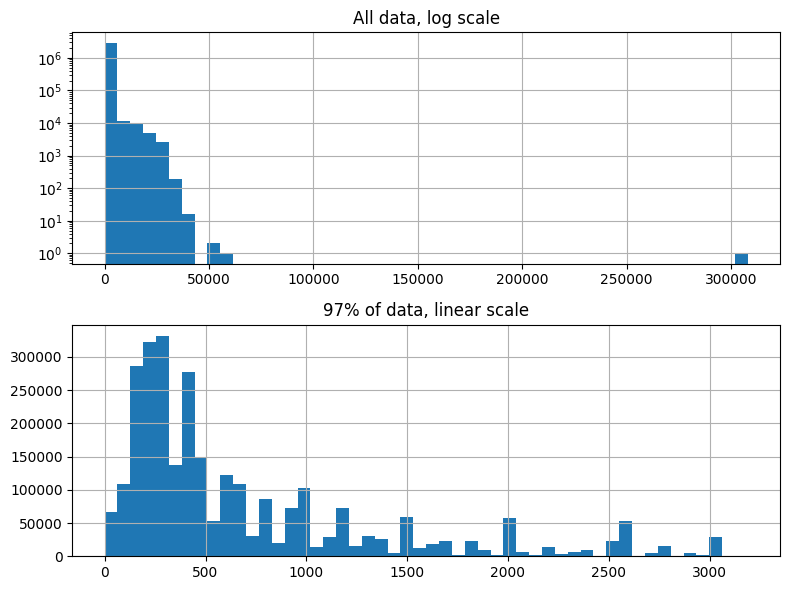

In [30]:
fig, ax = plt.subplots(2, 1 , figsize=[8, 6])
merged_df['item_price'].hist(log=True, bins=50, ax=ax[0])

cond = merged_df['item_price'] < merged_df['item_price'].quantile(.97)
merged_df[cond]['item_price'].hist(log=False, bins=50, ax=ax[1]);

ax[0].set_title('All data, log scale'); ax[1].set_title('97% of data, linear scale')
plt.tight_layout()

The column was highlighted as heavily skewed. On 2 hist plots drawn we see that it's is indeed heavily right skewed with long right tale. Meaning that most prices are around 900 with 50% of data spread between that and 300000. The field has high varience, as we've previously seen, std is about double the mean.

<a name='1-2-3'></a>
### `item_cnt_day` column

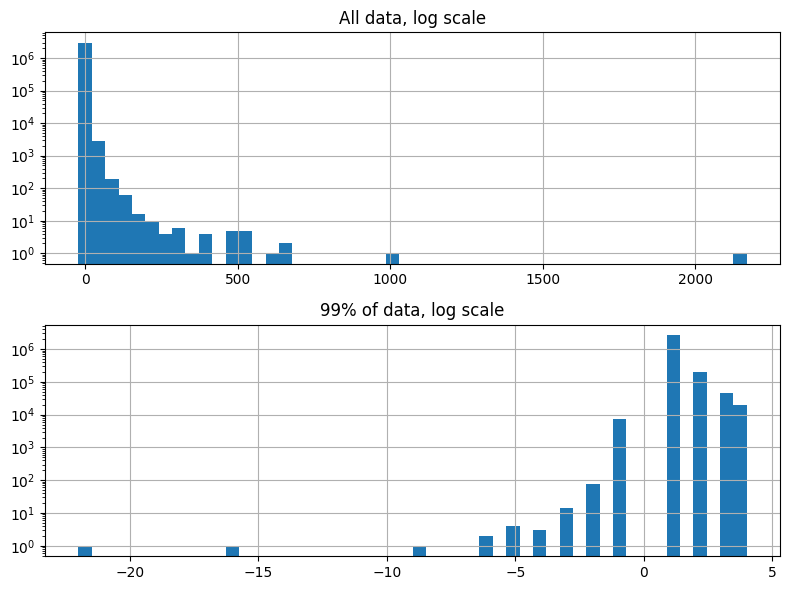

In [32]:
fig, ax = plt.subplots(2, 1 , figsize=[8, 6])
merged_df['item_cnt_day'].hist(log=True, bins=50, ax=ax[0])
    
cond = merged_df['item_cnt_day'] < merged_df['item_cnt_day'].quantile(.99)
merged_df[cond]['item_cnt_day'].hist(log=True, bins=50, ax=ax[1]);

ax[0].set_title('All data, log scale'); ax[1].set_title('99% of data, log scale')
plt.tight_layout()

So, as we've seen from .describe() output majority of the data points has the value of 1 in this target field, only 1% is above 5. Some values are negative. We are assuming those represent returns of goods.

<a name='1-2-4'></a>
### Duplicates

In [33]:
merged_df[merged_df.duplicated(keep=False)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
76961,2013-01-05,0,54,20130,149.0,1.0,40
76962,2013-01-05,0,54,20130,149.0,1.0,40
1435365,2014-02-23,13,50,3423,999.0,1.0,23
1435367,2014-02-23,13,50,3423,999.0,1.0,23
1496765,2014-03-23,14,21,3423,999.0,1.0,23
1496766,2014-03-23,14,21,3423,999.0,1.0,23
1671872,2014-05-01,16,50,3423,999.0,1.0,23
1671873,2014-05-01,16,50,3423,999.0,1.0,23
1866322,2014-07-12,18,25,3423,999.0,1.0,23
1866340,2014-07-12,18,25,3423,999.0,1.0,23


We see that indeed there are 6 rows that are duplicated. But because we will be reformating the dataset by calculating window agregates, there is no need to remove these rows

<a name='2'></a>
# Seasonality / cycles

In [ ]:
# TODO: analyse what cycles are present in the target value. use statsmodel.tsa.seasonal.seasonal_decompose

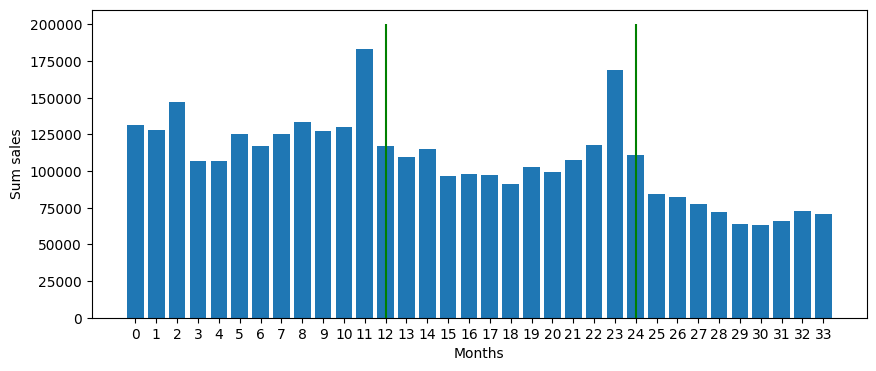

In [120]:
sum_sales_per_months = merged_df.groupby('date_block_num')['item_cnt_day'].sum()

plt.figure(figsize=[10, 4])
plt.bar(sum_sales_per_months.index, sum_sales_per_months.values)
plt.xticks(ticks=sum_sales_per_months.index, labels=sum_sales_per_months.index);
plt.xlabel('Months'); plt.ylabel('Sum sales')

for mnth in [12, 24]:
    plt.vlines(x=mnth, ymin=0, ymax=2e5, color='green')

Let's select most popular shops-items and look at their mean sales dynamics throughout the year

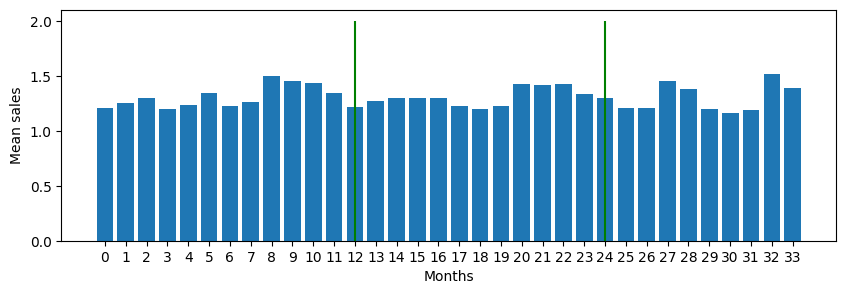

In [160]:
top_shop_items = merged_df.groupby(['shop_id', 'item_id'], as_index=False)['item_cnt_day']\
    .mean().sort_values('item_cnt_day', ascending=False)[:50000]

shop_cond = merged_df['shop_id'].isin(top_shop_items['shop_id'])
item_cond = merged_df['item_id'].isin(top_shop_items['item_id'])

sum_sales_per_months = merged_df[shop_cond & item_cond].groupby('date_block_num')['item_cnt_day'].mean()

plt.figure(figsize=[10, 3])
plt.bar(sum_sales_per_months.index, sum_sales_per_months.values)
plt.xticks(ticks=sum_sales_per_months.index, labels=sum_sales_per_months.index);
plt.xlabel('Months'); plt.ylabel('Mean sales')

for mnth in [12, 24]:
    plt.vlines(x=mnth, ymin=0, ymax=2, color='green')

(0.0, 20000.0)

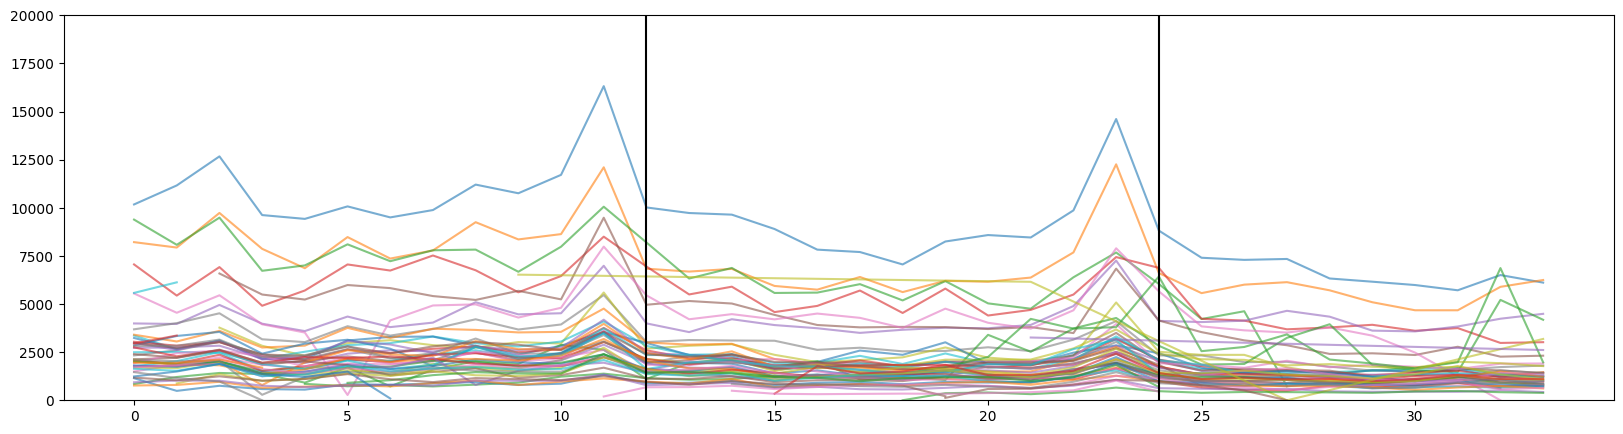

In [159]:
top_shops = merged_df.groupby(['shop_id'], as_index=False)['item_cnt_day'].sum()\
    .sort_values('item_cnt_day', ascending=False).reset_index(drop=True)[:50000]

plt.figure(figsize=(20, 5))
for shop_num in top_shops['shop_id']:
    plt.plot(merged_df[merged_df['shop_id']==shop_num].groupby('date_block_num')['item_cnt_day'].sum(), alpha=.6)

for mnth in [12, 24]:
    plt.vlines(x=mnth, ymin=0, ymax=2e4, color='black')
plt.ylim(0, 2e4)


So 2 things are evident:
- end of the year peak in sum and mean sales
- cycles in mean sales inside one year with increases around 2-3 and 8-9 months
- absense of downward trend in mean monthly sales
- slow overall downward trend in sum of monthly sales

Based on this, lag features should work.

<a name='3'></a>
# Test set

The only thing to check here is how row IDs are constructed and if they match those in the train set

We are given information that we need to forecast the sales for shops in the test set and products for November 2015. In terms of values of the `date_block_num` field, this is month 34.

In [98]:
test_df = pd.read_csv(RAW_PATH + 'test.csv')
test_df.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


Yes, we see that the test dataset is indexed by shop_id and item_id. So we are asked to predict the sum number of items sold for a given shop_id and item_id.
Let's check that shop_ids and item_ids match the ones we have in the train set.

In [173]:
test_shops = set(test_df.shop_id.unique())
train_shops = set(merged_df.shop_id.unique())

test_items = set(test_df.item_id.unique())
train_items = set(merged_df.item_id.unique())

train_item_cats = set(merged_df.item_category_id.unique())

item_cats = pd.read_csv(RAW_PATH + 'items.csv')
all_item_ids = set(item_cats.item_id.unique())

In [150]:
# checking if shops from test are preset in train
set(test_shops).issubset(train_shops)

True

In [151]:
# checking if items from test are preset in train
test_items.issubset(train_items)

False

In [166]:
# checking which item_ids from test set are not present in the train set
items_dif = test_items.difference(train_items)
print(f'{len(items_dif)} items from the test set are not present in the train set, which is:', 
      f'\n{round(len(items_dif) * 100 / len(test_items), 2)}% of the test set')

363 items from the test set are not present in the train set, which is: 
7.12% of the test set


So about 7% of items in the test set are new, not seen in train. Let's check the same with the item_categories table.

In [171]:
set(test_items).issubset(all_item_ids)

True

Ok, so even though there are new item_ids in the test, at least we know how to categorise all of those new items.
Let's check if items that were not present in the train set belong to item categories that are present in train.

In [174]:
set(item_cats[item_cats['item_id'].isin(items_dif)]['item_category_id'].unique()).issubset(train_item_cats)

True

Great, so even through we won't be seeing all of the items from the test set in training, those new items belong to categories that are present at training and they are sold in shops that we also see during training. This means that our features should be calculated not only for item_ids but also for item catogories and shops. This way when new item is encountered at test time we are able to build aggregates for it based on respective category and shop and infer the target based on that.